# Case Study: Classification

This dataset is a **classification problem**, concerning whether if the loan was approved or not.

- **Loan_ID** - unique loan ID
- **Gender** - male/female
- **Married** - yes/no
- **Dependents** - number of dependents
- **Education** - graduate/undergraduate
- **Self_Employed** - yes/no
- **ApplicantIncome** - applicant income
- **CoapplicantIncome** - coapplicant income
- **LoanAmount** - loan amount in thousands
- **Loan_Amount_Term** - term of lean in months
- **Credit_History** - credit history meets guidelines
- **Property_Area** - Urban/semi and Rural
- **Loan_Status** - approved yes/no 

We are given 2 set, the training set and the test set.

The **training set** contains 614 samples and 13 features, 12 of which are the independent variables and the last feature `Loan_Status` is the dependent variable.

The **test set** contains 367 samples with the same 12 features but without the `Loan_Status` columns. So it will be representing the unseen data that we will be implementing our model on.

In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

In [2]:
pd.__version__

'1.5.3'

In [3]:
np.__version__

'1.23.5'

In [4]:
import matplotlib
matplotlib.__version__

'3.7.1'

## 1. Load the data

In [5]:
#get the data from google classroom
#kaggle competition
df_train = pd.read_csv("data/train_LoanPrediction.csv")
df_test  = pd.read_csv("data/test_LoanPrediction.csv")

In [6]:
#1. get the shape (rows, columns)
df_train.shape  #(614 rows, 13 columns)

#2. try .head()
df_train.head()
# df_train.info()

#3. try .describe()
# df_train.describe()

#4. check whether our data class is balanced, using value_counts(normalize=True)
# df_train['Loan_Status'].value_counts() #if you don't put normalize=True, will give you raw number

#our class is imbalanced....
#it means, we have to downsample Y, to equal N

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [18]:
df_train['ApplicantIncome'].max()

81000

In [20]:
condMaxAI = df_train['ApplicantIncome'] == 81000
df_train[condMaxAI]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Semiurban,Property_Area_Urban
409,LP002317,Male,Yes,3+,0,No,81000,0.0,360.0,360.0,0.0,0,0,0


In [21]:
df_train.loc[409]

Loan_ID                    LP002317
Gender                         Male
Married                         Yes
Dependents                       3+
Education                         0
Self_Employed                    No
ApplicantIncome               81000
CoapplicantIncome               0.0
LoanAmount                    360.0
Loan_Amount_Term              360.0
Credit_History                  0.0
Loan_Status                       0
Property_Area_Semiurban           0
Property_Area_Urban               0
Name: 409, dtype: object

In [7]:
df_train['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

### Balance the class

- We need to balance the label in the training set, because imbalanced class affects the model during training
- If we do not balance the class, you can also try look at the SMOTE (https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) algorithm which dynamically augments data on the fly.

In [8]:
#1. set the cond = Y, and cond = N
condY = df_train.Loan_Status == 'Y'  #to 0 or 1
condN = df_train.Loan_Status == 'N'

#2.. df[condY].sample(n = 192)
#    df[condN].sample
#    we do this many times, do whole ML thing, and do the average....
df_trainY = df_train[condY].sample(n=192, random_state=999)
df_trainN = df_train[condN] #also 192

#3. concat these two dfs
df_train = pd.concat([df_trainY, df_trainN])

df_train.Loan_Status.value_counts()


Y    192
N    192
Name: Loan_Status, dtype: int64

### Label encoding

This is a useful step to do before EDA, so that categories are turned into numbers.


In [9]:
df_train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [10]:
#do label encoding the Loan Status
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_train['Loan_Status'] = le.fit_transform(df_train['Loan_Status'])

#very interesting...our testing set has no loan status, because this is actually a real testing set....

print("I want to know the mapping of 0 and 1", le.inverse_transform([0, 1]))

I want to know the mapping of 0 and 1 ['N' 'Y']


In [11]:
#label encode education as well
df_train['Education'] = le.fit_transform(df_train['Education'])
df_test['Education']  = le.transform(df_test['Education'])

#optionally you can use pd.map
#df_train.map({'Graduate': 0, 'Not Graduate': 1})

### One hot encoding

In [12]:
df_train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [13]:
df_train.Property_Area.value_counts()

Semiurban    135
Urban        131
Rural        118
Name: Property_Area, dtype: int64

In [14]:
#why one-hot encode Property Area, not encode it into 0, 1, 2
#if we have more than two categories, if we encode into 0, 1, 2
#we create a unintentional order, i.e., the model "may" think that 0 < 1 < 2

#what if we have like 5000 categories....
    #one hot encode this will result in 5000 columns --> this introduces burden to the machine learning model
    #1. NLP --> we basically do like this....
    #2. General case -->
        #1st:  Group these categories into bigger categories, and then one-hot encode
        #2nd:  (not so good) - do label encoding anyway......but note the possible order effect
        
#one hot encoding
#[1, 0, 0], [0, 1, 0], [0, 0, 1]
#one thing you need to know is that you can always cut down one column
#[1, 0], [0, 1], [0, 0]  ==> this is possible, and will save you one more column...
#also this is recommended, because it will not introduce unwanted correlation.....
#this is done by setting "drop_first=True"

df_train = pd.get_dummies(df_train, columns=['Property_Area'], drop_first=True)
df_test  = pd.get_dummies(df_test,  columns=['Property_Area'], drop_first=True)

In [15]:
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Semiurban,Property_Area_Urban
294,LP001947,Male,Yes,0,0,No,2383,3334.0,172.0,360.0,1.0,1,1,0
501,LP002606,Female,No,0,0,No,3159,0.0,100.0,360.0,1.0,1,1,0
323,LP002055,Female,No,0,0,No,3166,2985.0,132.0,360.0,NaN,1,0,0
467,LP002501,NaN,Yes,0,0,No,16692,0.0,110.0,360.0,1.0,1,1,0
476,LP002529,Male,Yes,2,0,No,6700,1750.0,230.0,300.0,1.0,1,1,0


## 2. EDA (Exploratory Data Analysis)

In [22]:
#0. Check the data type
df_train.dtypes
df_train.drop(columns = ['Loan_ID'], inplace=True)  #this is not a useful feature....
df_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status',
       'Property_Area_Semiurban', 'Property_Area_Urban'],
      dtype='object')

In [23]:
import seaborn as sns

#1. You want to divide into categorical and numerical columns using select_dtypes
df_train.dtypes
num_col = df_train.select_dtypes(include=['int64', 'float64'])
# numcol = numcol.drop([]) #Loan_Status
cat_col = df_train.select_dtypes(exclude=['int64', 'float64'])
num_col.columns, cat_col.columns

(Index(['Education', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
        'Loan_Amount_Term', 'Credit_History', 'Loan_Status'],
       dtype='object'),
 Index(['Gender', 'Married', 'Dependents', 'Self_Employed',
        'Property_Area_Semiurban', 'Property_Area_Urban'],
       dtype='object'))

### Bar plots

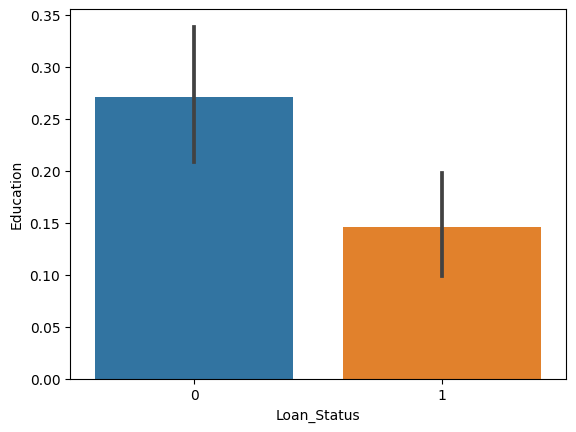

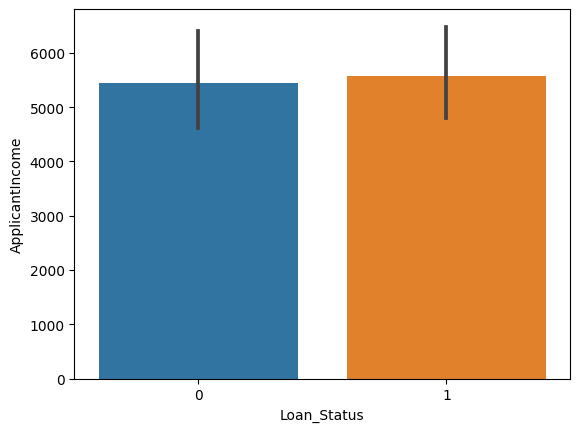

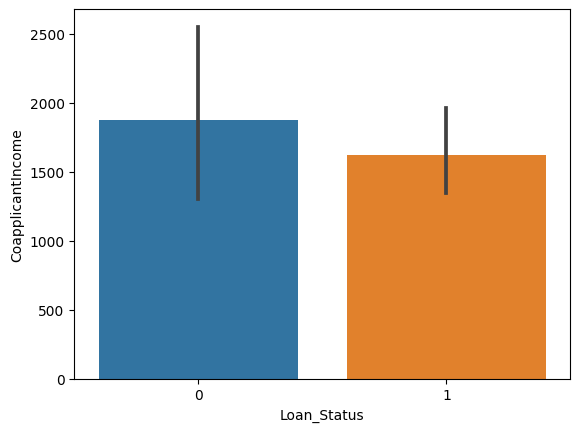

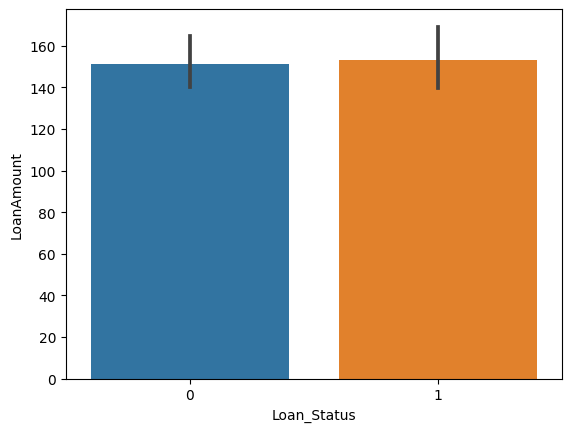

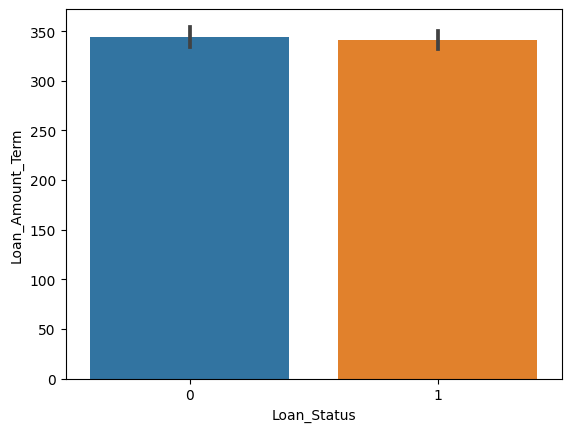

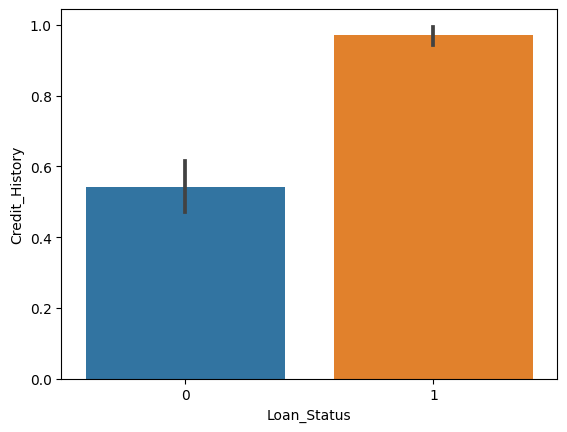

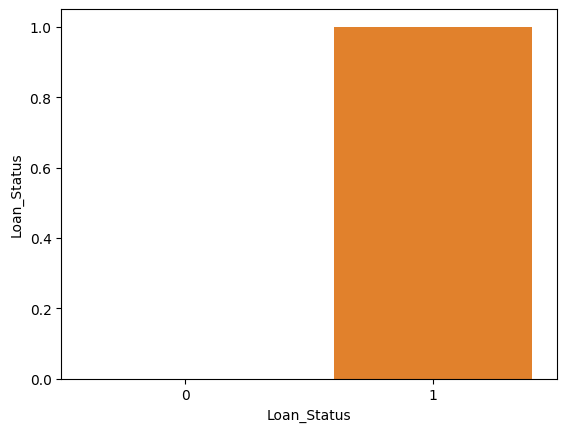

In [24]:
#2. for numerical type, lets plot some a bar plot with Loan Status
for col in num_col.columns:
    sns.barplot(x = df_train['Loan_Status'], y = df_train[col])
    plt.show()

### Countplot / Histogram

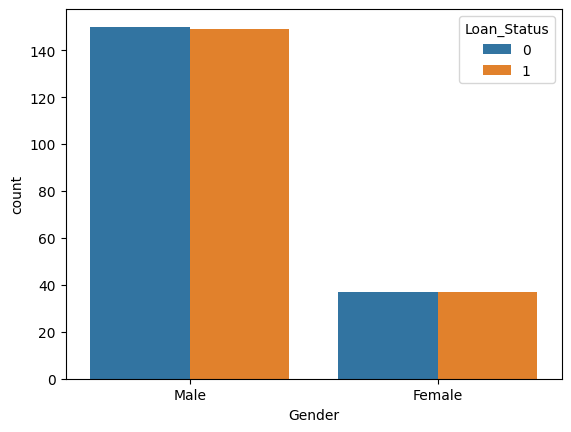

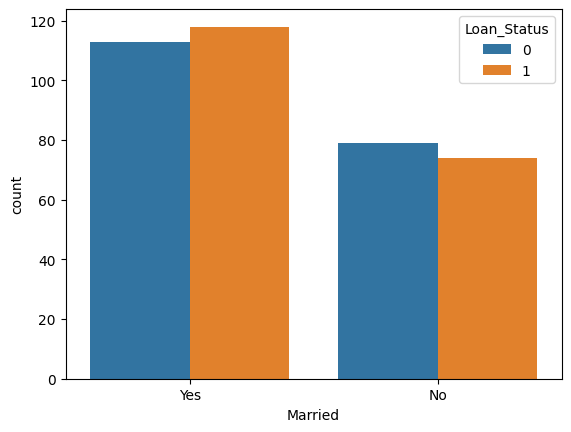

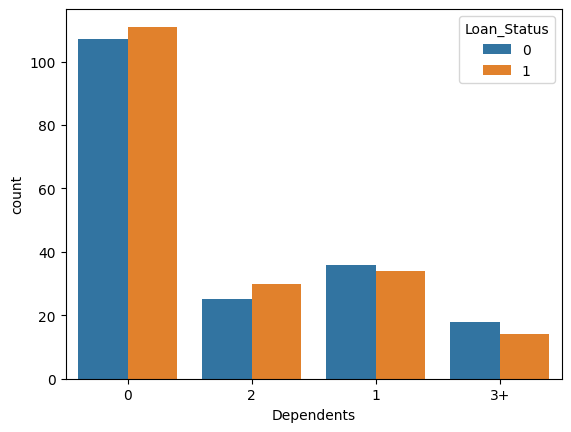

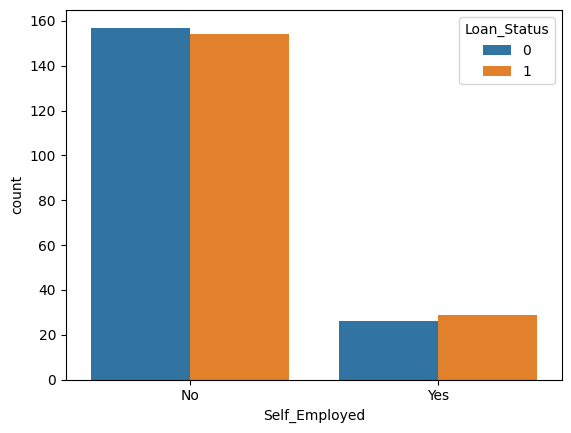

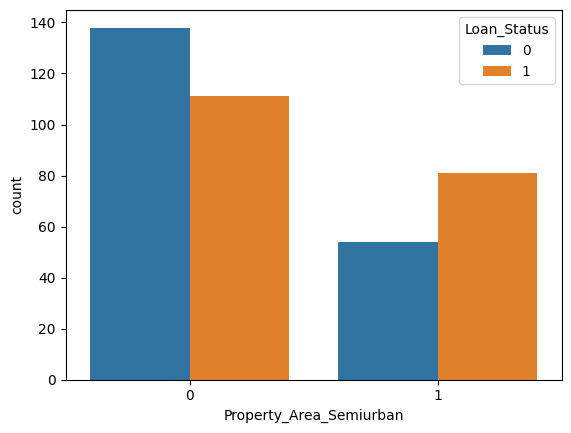

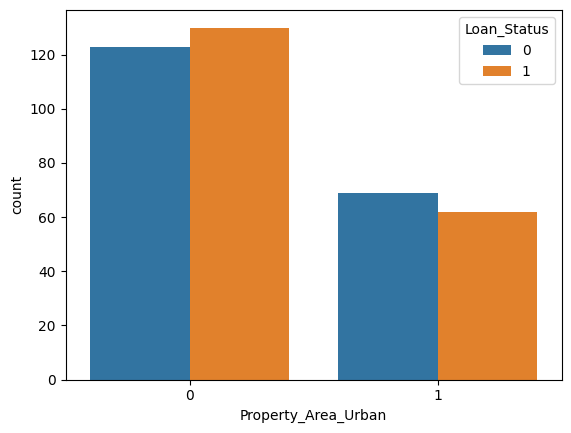

In [25]:
#3. for categorial type, you may want to use countplot with Loan Status
for col in cat_col.columns:
    sns.countplot(x = df_train[col], hue = df_train['Loan_Status'])
    #similar to hue in scatterplot
    plt.show()
    # sns.countplot()  #because categorical, you need to count, not simply use the magnitude...so cannot use bar...

### Correlation matrix

/var/folders/1v/1h7r513n71j7569x87spb4b40000gn/T/ipykernel_34101/1263653214.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(), annot=True)  #this is only for numeric values....


<Axes: >

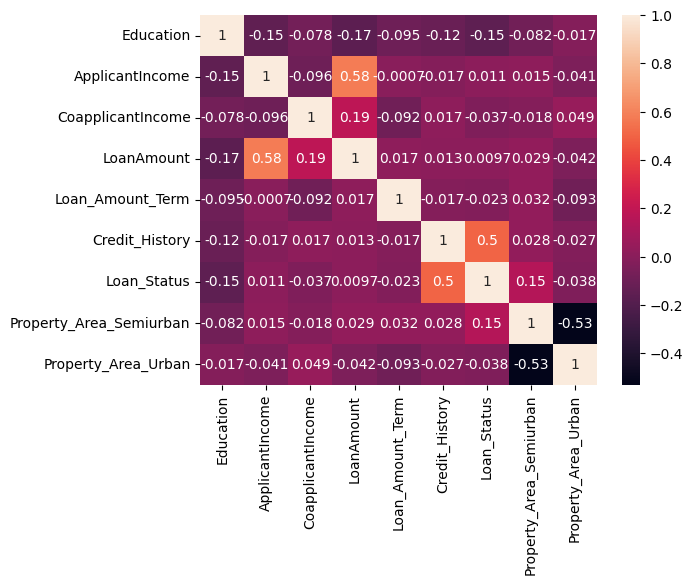

In [27]:
sns.heatmap(df_train.corr(), annot=True)  #this is only for numeric values....

### Predictive Power Score

<Axes: xlabel='x', ylabel='y'>

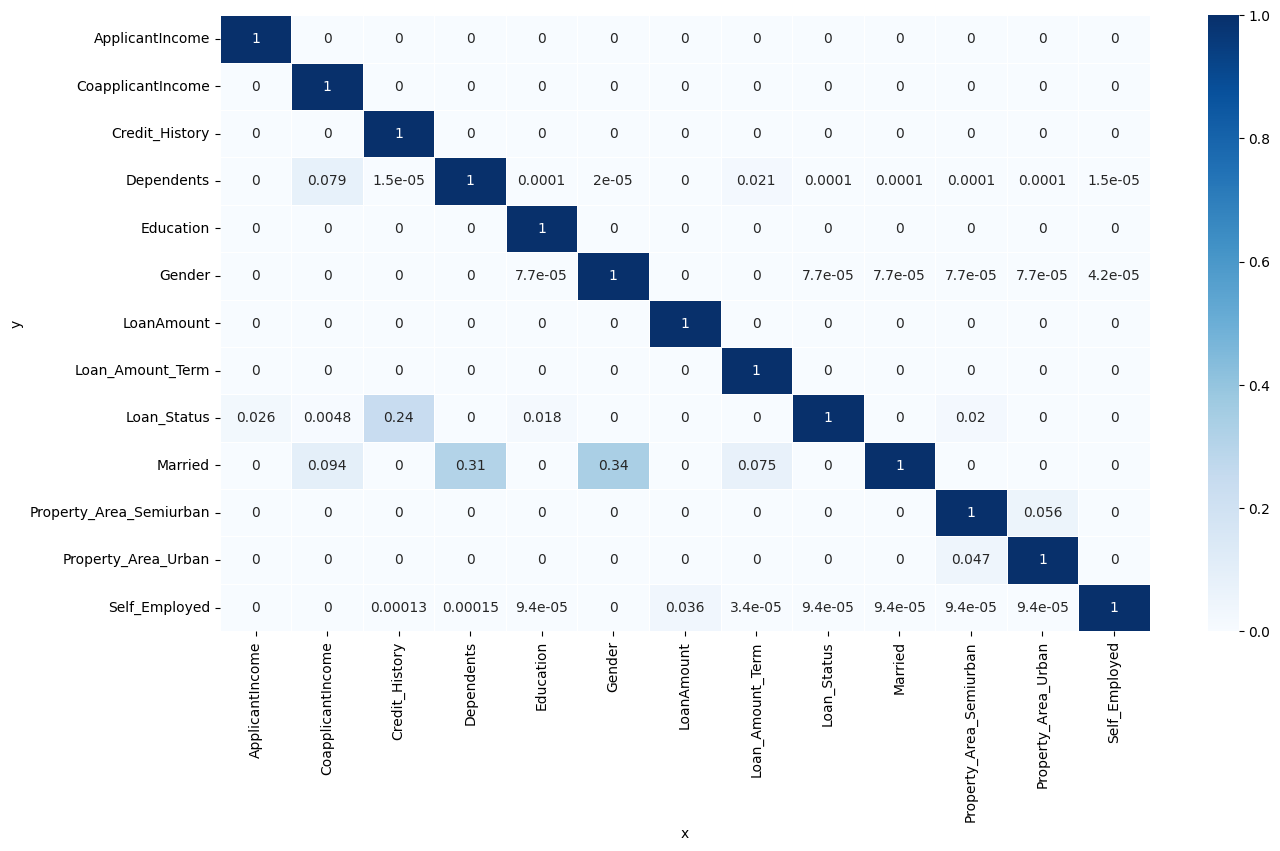

In [29]:
import ppscore as pps

# before using pps, let's drop country and year
dfcopy = df_train.copy()

#this needs some minor preprocessing because seaborn.heatmap unfortunately does not accept tidy data
matrix_df = pps.matrix(dfcopy)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

#plot
plt.figure(figsize = (15,8))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

## 3. Feature Engineering

Skipped

## 4. Feature Selection

Since our dataset is already splitted at the dataset level, thus we do not need to hurry to select the features.  We can preprocess and then select later.

#forward selection - process of starting with one feature, and slowly adding one feature at a time, until the performance does not improve by certain threshold you want.

## 5. Preprocessing

### Null values

In [30]:
#1. please check the missing value in df_train, and of course df_test
df_train.isna().sum()

#Gender:            majority or ratio
#Dependents:        majority or ratio
#Self_Employed:     majority or ratio
#LoanAmount:        median or mean
#Loan_Amount_Term:  majority or ratio
#Credit_History:    majority or ratio

Gender                     11
Married                     0
Dependents                  9
Education                   0
Self_Employed              18
ApplicantIncome             0
CoapplicantIncome           0
LoanAmount                 14
Loan_Amount_Term           10
Credit_History             28
Loan_Status                 0
Property_Area_Semiurban     0
Property_Area_Urban         0
dtype: int64

If we have a missing categorical feature, we can replace with three things:
- mode (most frequent) --> bad
- ratio (keep the ratio intact) --> preferred
- "No category" --> believe replacing is not a good option

In [32]:
ratio = df_train['Credit_History'].value_counts(normalize=True)
print(ratio)

1.0    0.755618
0.0    0.244382
Name: Credit_History, dtype: float64


In [33]:
ratio.dtypes

dtype('float64')

In [34]:
type(ratio)

pandas.core.series.Series

In [35]:
# #either replace with the majority or keep the ratio
# #majority is good when the majority takes over like 90% of the population
# #otherwise, ratio is better

# #in this case, it's better to fill the missing value with ratio
# #ratio means that we want to keep the ratio 75 25 AFTER filling....
print("Credit history of 1: ", ratio[1])
print("Credit history of 0: ", ratio[0])
print(ratio.index)


Credit history of 1:  0.7556179775280899
Credit history of 0:  0.2443820224719101
Float64Index([1.0, 0.0], dtype='float64')


In [37]:
# #we gonna fill the missing value such that the ratio is kept unchanged
# #format: fillna(pd.Series(random.choice(1, 0), p=probability of the ratios), inplace=True)
missing = df_train.Credit_History.isna().sum()

num1 = int(np.round(ratio[1] * missing))
num0 = int(np.round(ratio[0] * missing))

print(num1, num0)


21 7


In [38]:
df_train['Credit_History'].fillna(1.0, limit = num1, inplace=True)
df_train['Credit_History'].fillna(0.0, limit = num0, inplace=True)

#pd.series is ok, but i feel like limit is much easier

In [41]:
df_train['Credit_History'].isna().sum()

0

In [42]:
#fill the missing for the test set for credit history

#number of missing values
missing = df_test['Credit_History'].isna().sum()

#get the row index where the missing values located at
cond = df_test['Credit_History'].isna()  #list of true and false
missing_index = df_test[cond].index

#get ratio
ratio = df_test['Credit_History'].value_counts(normalize=True)
print("Test ratio: ", ratio)

series = pd.Series(np.random.choice((1, 0), p=[ratio[1], ratio[0]], size=missing), index=missing_index)
print(series.value_counts(normalize=True))

print("Before: ", df_test['Credit_History'].isna().sum())
print("Before: ", df_test['Credit_History'].value_counts(normalize=True))

df_test['Credit_History'].fillna(series, inplace=True)
df_test['Credit_History'].isna().sum()

print("After: ", df_test['Credit_History'].isna().sum())
print("After: ", df_test['Credit_History'].value_counts(normalize=True))

Test ratio:  1.0    0.825444
0.0    0.174556
Name: Credit_History, dtype: float64
1    0.862069
0    0.137931
dtype: float64
Before:  29
Before:  1.0    0.825444
0.0    0.174556
Name: Credit_History, dtype: float64
After:  0
After:  1.0    0.828338
0.0    0.171662
Name: Credit_History, dtype: float64


median: 128.0; mean: 152.14864864864865


Gender                     11
Married                     0
Dependents                  9
Education                   0
Self_Employed              18
ApplicantIncome             0
CoapplicantIncome           0
LoanAmount                  0
Loan_Amount_Term           10
Credit_History              0
Loan_Status                 0
Property_Area_Semiurban     0
Property_Area_Urban         0
dtype: int64

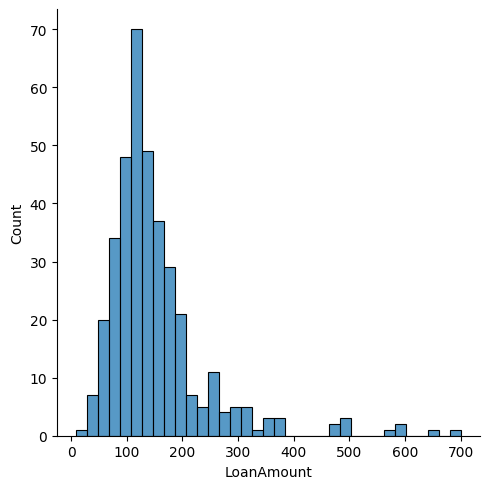

In [43]:
sns.displot(df_train.LoanAmount)
print(f"median: {df_train.LoanAmount.median()}; mean: {df_train.LoanAmount.mean()}")

#can you guys help me fill in the LoanAmount with median()
df_train['LoanAmount'].fillna(df_train['LoanAmount'].median(), inplace=True)

df_train.isna().sum()

Here I stop because I am too lazy as the rest of the features won't be used for training.

In [44]:
df_test.isna().sum()

Loan_ID                     0
Gender                     11
Married                     0
Dependents                 10
Education                   0
Self_Employed              23
ApplicantIncome             0
CoapplicantIncome           0
LoanAmount                  5
Loan_Amount_Term            6
Credit_History              0
Property_Area_Semiurban     0
Property_Area_Urban         0
dtype: int64

### Scaling

In [45]:
#StandardScaler is usually used for continuous values
#here, Education, Credit_History, and Property Area are all categorical
#standardizing them will lose the category, so we will not do!!!

## 6. Modeling

In [46]:
#1. set the X and y
X_train = df_train[ ['Education', 'Credit_History', 'Property_Area_Semiurban', 'Property_Area_Urban'] ]
y_train = df_train['Loan_Status']

X_test = df_test[ ['Education', 'Credit_History', 'Property_Area_Semiurban', 'Property_Area_Urban'] ]
#no y_test, because this dataset does not have the answer....

#2. make sure the shape of X is (samples, features), and y is (samples, )
assert X_train.ndim == 2
assert X_test.ndim  == 2
assert y_train.ndim == 1

print("(samples, features): ", X_train.shape)
print("(samples,         ): ", y_train.shape)
print("(samples, features): ", X_test.shape)


(samples, features):  (384, 4)
(samples,         ):  (384,)
(samples, features):  (367, 4)


In [47]:
#3. perform cross validation with a selected set of models, to scope down which model is among the best

#3.1 specify the list of algorithms
#this is for classification
##Baselines
from sklearn.linear_model import LogisticRegression  #drawing a line based on linear regression but used for classification
from sklearn.naive_bayes import GaussianNB  #drawing a line based on probability

##Situational (but we don't use much)
from sklearn.neighbors import KNeighborsClassifier

##Complex
from sklearn.ensemble import RandomForestClassifier  #using trees to classify
from sklearn.svm import SVC  #drawing a line based on maximum distance
from sklearn.ensemble import GradientBoostingClassifier  #<<-------is the MOST complex
    #XGBoost but is not in sklearn, import XGBoost #<---most powerful algorithm for tabular data (not images, signal)

#any random_state you can use......up to you 
lr = LogisticRegression(random_state=999)
rf = RandomForestClassifier(random_state=999)
sv = SVC(random_state=999)

models = [lr, rf, sv]

#3.2 perform cross validation using KFold
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits = 5, shuffle = True, random_state=999)

for model in models:
    score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')  #f1, recall, precision, accuracy
    print("Scores: ", score, "- Scores mean: ", score.mean(), "- Scores std (lower better): ", score.std())  #out of 1 ; 1 means perfect accuracy
    #lr, rf, sv

#when they are very close, 
    #how we choose?  we choose the simplest model...
    #what does simplest mean?  LogisticRegression is simplest, and SVM is the most complex....
    
#overfitting vs. underfitting
#overfitting means your model learns too much about the training set, 
    #so it cannot generalize to validation set or testing set (unseen data)
    #is NOT good - it means your model CANNOT GENERALIZE to unseen data (validation or test set)
    
#underfitting means your model just fail to see any patterns in the training set
    #this is easy: just look at score

Scores:  [0.74025974 0.63636364 0.74025974 0.72727273 0.73684211] - Scores mean:  0.7161995898838005 - Scores std (lower better):  0.04020022129173056
Scores:  [0.74025974 0.63636364 0.74025974 0.72727273 0.68421053] - Scores mean:  0.7056732740943268 - Scores std (lower better):  0.04030746602254514
Scores:  [0.74025974 0.63636364 0.74025974 0.72727273 0.68421053] - Scores mean:  0.7056732740943268 - Scores std (lower better):  0.04030746602254514


In [48]:
#4. grid search to find the best version of that model
#remind you: grid search is BASICALLY same as cross validation but for the same model

from sklearn.model_selection import GridSearchCV

model = LogisticRegression(random_state=999)  #<----this is the model I choose, after cross validation

param_grid = dict()
param_grid['solver'] = ['newton-cg', 'lbfgs', 'liblinear']  #this is listed in the sklearn website

#add more parameters here
#param_grid[parameter] = list of parameters to search

#refit means it will pick the best model, and fit again, so it means grid is already the best model after this line
grid = GridSearchCV(model, param_grid, scoring="accuracy", cv=kfold, refit=True, return_train_score=True)
#scoring = f1, recall, precision, accuracy

#fit the grid, which will basically do cross validation across all combinatiosn, here we only have 3 comb
grid.fit(X_train, y_train)  #remember to use only training set here....

#print the best parameters and accuracy
# print(grid.best_params_)
# print(grid.best_score_)
print(grid.cv_results_)

#this score is cross-validation score, basically the accuracy/precision/etc on the validation set


{'mean_fit_time': array([0.00342798, 0.00182805, 0.00118866]), 'std_fit_time': array([0.00124178, 0.00022817, 0.00032428]), 'mean_score_time': array([0.00089898, 0.00067267, 0.00056891]), 'std_score_time': array([1.37959926e-04, 1.03082070e-04, 7.58649867e-05]), 'param_solver': masked_array(data=['newton-cg', 'lbfgs', 'liblinear'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'solver': 'newton-cg'}, {'solver': 'lbfgs'}, {'solver': 'liblinear'}], 'split0_test_score': array([0.74025974, 0.74025974, 0.74025974]), 'split1_test_score': array([0.63636364, 0.63636364, 0.63636364]), 'split2_test_score': array([0.74025974, 0.74025974, 0.77922078]), 'split3_test_score': array([0.72727273, 0.72727273, 0.72727273]), 'split4_test_score': array([0.73684211, 0.73684211, 0.73684211]), 'mean_test_score': array([0.71619959, 0.71619959, 0.7239918 ]), 'std_test_score': array([0.04020022, 0.04020022, 0.0472641 ]), 'rank_test_score': array([2, 2, 1],

0.8333333333333334
0.75
1.0
0.8571428571428571
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



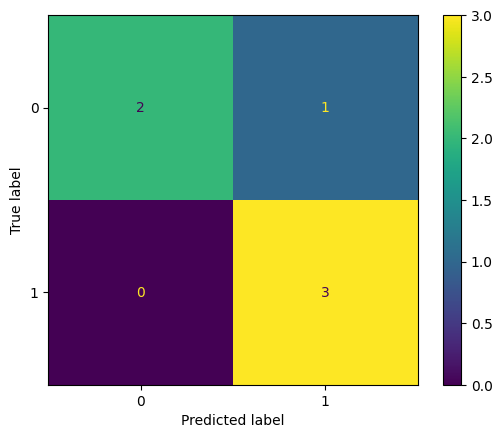

In [49]:
#confusion matrix 
'''
T = True, F = False
P = Positive, N = Negative
'''

''' 
                        Actual
                    P               N
             P     TP              FP
predict   
             N     FN              TN
'''

#0 here is negative
#1 here is positive

y     = [0, 0, 1, 1, 0, 1]
ypred = [1, 0, 1, 1, 0, 1]

#accuracy = (TP + TN) / (TP + FP + FN + TN)
#accuracy = 3 + 2  /  6 = 5 / 6 = 83%

#but accuracy is NOT good if your data is imbalanced (see actual y)

#recall, precision, f1-score
#recall = TP  / (TP + FN)
#recall = 3   / (3  + 0) = 100%  Recall is used when you don't like FN, e.g., critical - cancer, zombie, terrorists

#precision = TP / (TP + FP)
#precision = 3 /  (3 + 1) = 75% Precision is used when you don't like FP, e.g., search engine

#f1-score = 2 * ( (recall * precision) / (precision + recall) )
        #when precision and recall are both important.....
        #   2 * ( (1      * 0.75)     /   (0.75     +    1  ) )
        
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#if you want all in one table
from sklearn.metrics import classification_report

#if you want the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#format (ytrue, ypred)
print(accuracy_score(y, ypred))
print(precision_score(y, ypred))
print(recall_score(y, ypred))
print(f1_score(y, ypred))

print(classification_report(y, ypred))

cm = confusion_matrix(y, ypred)
cmp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])

cmp.plot()

#for regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## 7. Testing

In [50]:
pred_y = grid.predict(X_test)

print(pred_y)

#if we have y_test
#precision_score(y_test, pred_y)

#three cases (assume I have y_test):
    #if I got score much lower than 0.7, e.g., 0.5 0.4, i have serious overfitting issue
    #if I got score near 0.7 or just a little lower, or just a little higher, like 0.65 0.6 0.75, i think its ok
    #if I got score like much much higher than 0.7, like 0.95, something is wrong.....maybe your test set is broken or something
        #but this case rarely happens!
        
#overfitting means your model CANNOT GENERALIZE to unseen data....your unseen data can be validation or test set....

[1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1
 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0
 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0
 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1
 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0
 1 1 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1]


Since I don't really have the ground truth, I don't know the goodness of my model.  But let's assume I make some fake ground truth:

In [51]:
fake_y_test = np.random.randint(0, 2, size = (pred_y.shape))

In [52]:
accuracy_score(fake_y_test, pred_y)  #precision_score, recall_score, classification_report, confusion_matrix

0.5040871934604905

## 8. Analysis: Feature Importance

- Basically understanding which features are important for prediction
- Different algorithms have different way for feature importance
- For Logistic Regression, similar to Linear Regression, you can look at the coeffients/weights/slope

In [53]:
grid.best_estimator_

LogisticRegression(random_state=999, solver='liblinear')

In [54]:
grid.best_estimator_.coef_
#['Education', 'Credit_History', 'Property_Area_Semiurban', 'Property_Area_Urban']

#predict LoanStatus, LoanAmount

array([[-0.56963133,  2.69845542,  0.70551485,  0.11099812]])

<Axes: ylabel='features'>

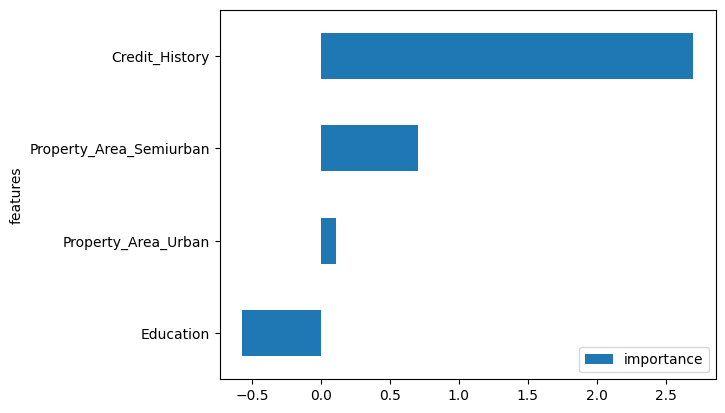

In [55]:
feature_importance = pd.DataFrame(['Education', 'Credit_History', 'Property_Area_Semiurban', 'Property_Area_Urban'], 
                                  columns=['features'])
feature_importance["importance"] = grid.best_estimator_.coef_[0]

feature_importance = feature_importance.sort_values(by = ['importance'], ascending=True)

feature_importance.plot.barh(x='features', y='importance')

## 9. Inference

In [56]:
import pickle

# save the model
filename = 'model/Loan_Prediction.pkl' # pkl does not matter, you can do .everything
pickle.dump(grid, open(filename,'wb'))

# Load the model
loaded_grid=pickle.load(open(filename,'rb'))

# if you have new data, then you fit again....but using loaded_grid
# which is a process of training more.....once you have more data....

# or another way is
# put all the dataset together, and train like it is new
    #this is possible ONLY if your dataset is not that big......

In [57]:
#let's try to create one silly example
df_train[['Education', 'Credit_History', 'Property_Area_Semiurban', 'Property_Area_Urban', 'Loan_Status']].loc[1]

Education                  0.0
Credit_History             1.0
Property_Area_Semiurban    0.0
Property_Area_Urban        0.0
Loan_Status                0.0
Name: 1, dtype: float64

In [58]:
sample = np.array([[0, 1, 0, 0]])

In [59]:
predicted_loan_status= loaded_grid.predict(sample)
predicted_loan_status

/Users/chaklam/Github/Machine-Learning/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([1])

It's wrong!  So certainly we need to improve the model :-)

## Group Workshop - Check your understandings

Answer the following questions:

Instruction:  Gather in your group.  Will randomly pick groups to present.

1.  Why this dataset is a classification problem?
    1.  Because `Loan_Status` is categorical, with 0 or 1
2.  How many samples of data do we have?  How many features do we have?  How many label do we have?
    1.  614 samples, 12 features, one label
3.  Why we need to fix class imbalances?  Explain in details.
    1.  Because your model will be confused....
4.  Discuss one-hot encoding vs. label encoding.
    1.  label encoding turn categories into incrementing numbres
        1.  2 categories, or 6+ categories
    2.  one-hot encoding turn categories into columns
        1.  3-5 categories
5.  Perform label encoding on "Self-Employed".
6.  Discuss when to replace with "majority" or "ratio" for categorical variables.
    1.  When majority makes sense to you; ask your domain expert
    2.  Ratio is very safe....
7.  Notice the "ApplicantIncome" can also be used as a feature, given it's good pps score.  
    1.  Scale the variable using `StandardScaler`
    2.  Add them into X
    3.  Does the accuracy improve?
8.  Explain what is overfitting vs. underfitting.  How do we know?
    1.  Overfitting means that your model learns a pattern too well, and the tendency to predict certain labels are skewed
    2.  Underfitting means that your model fails to learn a pattern
9.  Explain why accuracy can be deceiving and why precision/recall/f1-score can help.   
    1.  because accuracy can fool you, when model only predict the majority class
    2.  f1-score is the most common metric in the industry
10. There are other metrics like ROC curve.  Do a bit of research and explain what is it.
    1.  ROC curve, AUC curve - these are all based on four numbers
11. As you can see, we don't really have a test set with ground truths.  Do the followings:
    1.  Restart the whole notebook
    2.  Split the training set `train_LoanPrediction.csv` into training set and testing set
    3.  We will not use the `test_LoanPrediction.csv`
    4.  Run everything again, and report the model accuracy.
12. I did not teach the SMOTE API.  Please try the SMOTE upsampling.  Make sure to incorporate SMOTE inside the pipeline, NOT during preprocessing time.  Also remember never perform upsampling on the test set.